# **Understanding ICAs on EEG Data**

Rogene M. Eichler West, Ph.D.

January 2023


Organization of this document


1.   The Cocktail Party Problem
2.   Understanding Linear Transformations
1.   Singular Value Decomposition
1.   The Covariance Matrix
2.   Eigenvalues and Eigenvectors
1.   The Concept of Whitening Data
1.   The Requirement of Non-Gaussian Distributions
2.   Information Theory
2.   The Infomax ICA Algorithm
1.   Subtracting a Source
2.   Coherences Before and After
1.   Learning More About ICA











#**1. The Cocktail Party Problem**


Let's start off by reviewing the cocktail party problem and how it is related to source seperation in EEG. <br><br>

Imagine you are at party where there are N sources of sound, like people talking or music. Let's make this a managable number in our experiment to understand what is going on, say N=3.<br><br>

Let's also put M sensors in the room to detect the sound. You can think of these as microphones. Let's make M=4. <br><br>

The metaphor here to EEG is that we are modeling the N sound sources as cortical generators, and then the M microphones are our electrodes. <br><br>

*--- Note that you can change these numbers in the code, if you like, to generalize your understanding. Also notice that everytime you execute any cells where values are randomly selected, you will get a different answer. Note that a few cells may have been hardcoded to the initial dimensions of the scenario. *

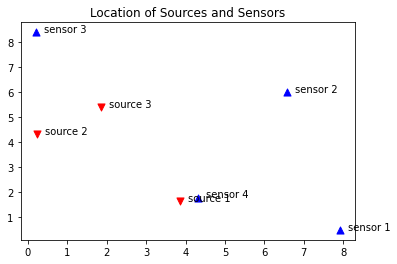

In [1]:
# We first need to do a bit of Python setup
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

# Here are the variables indicating the number of our sources and sensors.
N = 3
M = 4

# Let's randonly place them in a room of size 10 x 10.
size_room = 10

# These variables are where we will store their coordinates
N_locations = []
M_locations = []

# And now we will select the random locations
for i in range(N):
  x = random.uniform(0, size_room)
  y = random.uniform(0, size_room)
  N_locations.append((x,y))

for i in range(M):
  x = random.uniform(0, size_room)
  y = random.uniform(0, size_room)
  M_locations.append((x,y))

# Finally, let's visualize the room and the relative locations of our sources and sensors
plt.clf()
plt.title('Location of Sources and Sensors')

for i in range(N):
  x, y = N_locations[i]
  txt = 'source ' + str(i+1)
  plt.scatter(x, y, marker='v', s= 50, color='red')
  plt.annotate(txt, (x+.2, y))

for i in range(M):
  x, y = M_locations[i]
  txt = 'sensor ' + str(i+1)
  plt.scatter(x, y, marker='^', s= 50, color='blue')
  plt.annotate(txt, (x+.2, y))

plt.show()

Next, let's simulate the sound emanating from the sources. <br><br>

Voices, like at a cocktail party, have complex waveforms. But since we are trying to follow along with math in this tutorial, let's assign simple sin waves to two of the sources, and random noise to the third. 


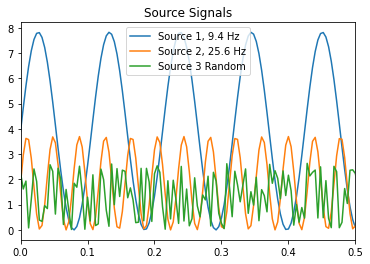

In [2]:
# Let's choose values in an EEG-like range
sampling_rate = 250.0 # Units, Hz
time_window = 60.0 # Total elapsed time in units, seconds
samples = np.arange(time_window * sampling_rate) / sampling_rate # arrange the timesteps in a array
total_timesteps = sampling_rate * time_window # This is how many timesteps in the samples array

# This is where we will store our source time series data and a list of the original frequencies
S = []
save_freq = []
save_amp = []

# For our sources, we will randomly select a frequency for all but the last source, which will be noise.
# I want to make sure that we randomly do not select values too close to each other so you can see the 
# difference in the plots, so I am setting the min and max frequencies to be selected from a band that 
# is a function of the number of sources.
min_freq = 1.0
max_freq = 40.0/float(N)

for i in range(N-1):
  random_freq = random.uniform(min_freq, max_freq)    # Create the sin wave at this frequency
  save_freq.append(random_freq)                       # Save it for later
  random_amplitude = random.uniform(1.0, 5.0)         # Generate amplitude for the waveform
  save_amp.append(random_amplitude)
  ts = random_amplitude * np.sin(2 * np.pi * random_freq * samples) + random_amplitude
  S.append(ts)

  # advance band for the next generator - see comment above
  min_freq = max_freq
  max_freq = 2.0 * max_freq

# for this last source, generate random values
random_amplitude = random.uniform(1.0, 10.0)
ts = random_amplitude * np.random.uniform(low=0.0,high=1.0,size=len(samples)) 
S.append(ts)

# Plot 500 msec of sources, so we can see detail
plt.clf()
plt.title('Source Signals')
for i in range(N):
  if i < N-1:
    txt = 'Source ' + str(i+1) + ', ' + str.format('{0:.1f}',save_freq[i]) + ' Hz'
  else:
    txt = 'Source ' + str(i+1) + ' Random'
  plt.plot(samples, S[i], label = txt)

plt.legend()
plt.xlim(left= 0, right=0.5)
plt.show()

With respect to the data collected by the sensors, you need to know two things. <br><br>

**First**, the amplitude of sound (and other kinds of signals such as electromotive forces and gravity) falls off with distance. Specifically, the attenuation is a function of the radius squared. <br><br>

**Second**, signals from indepdenent generators can be combined by simply adding their waveforms.<br><br>

Now let's model the signal measured by each sensor. 

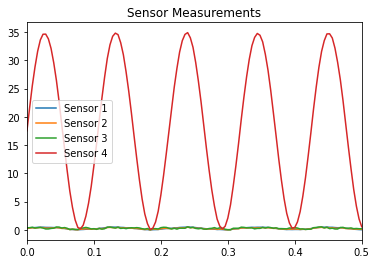

In [3]:
# This is where we will store our sensor measurements and our distance attentuation factors
X = []
A = np.zeros([M,N])

for i in range(M):
  ts = 0
  for j in range(N):
    # Calculate the distance between each source and sensor
    dist = math.dist(M_locations[i],N_locations[j])
    # Save this value because we will use it later
    A[i][j] = 1.0/(dist*dist)
    # Add data from each source, attenuated by the distance away
    ts = ts + (A[i][j] * S[j])
  X.append(ts)

# Plot 500 msec of sensor measurements, so we can see the details
plt.clf()
plt.title('Sensor Measurements')
for i in range(M):
  txt = 'Sensor ' + str(i+1)
  plt.plot(samples, X[i], label = txt)

plt.legend()
plt.xlim(left= 0, right=.5)
plt.show()

Before we go on, pause for a moment and make sure that you agree that these are the signals we would expect to measure at each location. If you refresh each cell starting from the top, new random locations and frequencies will be selected.

We know that **X**, our **measurements**, are just a linear combination of the **source data**, **S**, because we just constructed them this way! By "linear", this means that we performed operations like multiplying them by constants or adding them together.<br><br>

While we performed these operations computationally using a "loop" above so as to gain some intuition. However, we could also more concisely express this relationship as a maxtrix equation:<br><br>

X = AS

where **A** is also known as a ***mixing matrix***.


In [4]:
# Change the data structure for easier use of python methods
X = np.array(X)
A = np.array(A)
S = np.array(S)

# Print the shape of each matrix
print("X Shape:" + str(X.shape))
print("A Shape:" + str(A.shape))
print("S Shape:" + str(S.shape))

# Calculate the answer again using matrix multiplication
Y = np.matmul(A,S)

# Check if we get the same answer as our "for loop" above
if np.isclose(X, Y, atol=1e-8).all():
    print("\nWe get the same sensor measurements by maxtrix multiplication.") 


X Shape:(4, 15000)
A Shape:(4, 3)
S Shape:(3, 15000)

We get the same sensor measurements by maxtrix multiplication.


The problem is, we also don't know our mixing matrix **A**, representing the distances between our source and sensors. If we knew **A**, we could multiply each side of the equation by it's inverse to obtain our original sensor values, **S**. 

**A$^{-1}$X = A$^{-1}$AS**

**A$^{-1}$X = S**

<br>
Here is a quick check to make sure that we get the same answer using matrix multiplication.


In [5]:
# Let's check by taking the inverse of A (it is not a square matrix, so I am using the pseudoinverse method)
A_inv = np.linalg.pinv(A)

# Now multiply and see if we get S back
S_est = np.matmul(A_inv,X)

# Check to see if we get the same answer as the sources we generated above
if np.isclose(S, S_est, atol=1e-8).all():
    print("The recovered signals are the same as the ones we generated above.") 

The recovered signals are the same as the ones we generated above.


We are going to refer to the inverse of our mixing matrix, **A$^{-1}$**, as our "unmixing" matrix and give it a new name, **W**. 

**WX = S**

So now we have one equation with two unknowns. We have our measurements (microphones, electrodes), and we want to know the source and the distance relationships.
<br><br>

At this point, we should pause to discuss a few concepts about linear transformations so that we might gain some insight into the clues within the structure of our measurement matrix, **X**.

# **2. Understanding Linear Transformations**

Matrix operations, like combining source data scaled by the inverse distances to each sensor, is known as a linear transformation. <br><br>

Despite the mathematical sounding name, it is just a way to refer to a collection of operations - such as translation, scaling, rotation, reflection, and shear - which are commonly used with images. You were probably first introduced to these concepts in elementry school, but without the jargon. [Remember this?](https://www.mathsisfun.com/geometry/transformations.html)  
<br><br>
To make this more familiar, this next section of code demonstrates 2-dimensional visual examples of matrix operations. These are the kinds of operation that take place under the hood when you manipulate images in a program like Photoshop or in an app on your phone. 
<br><br>
The transformation marked "Combination" contains values that produce both scaling, shearing, and rotation.

<Figure size 432x288 with 0 Axes>

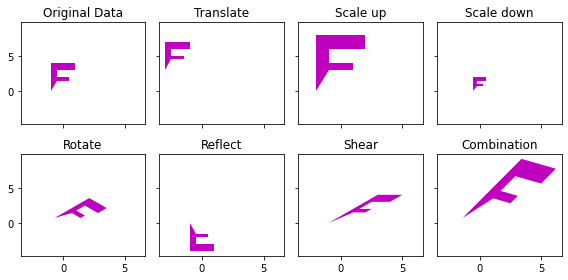

In [6]:
# Let's use a familiar square shape, centered at 0,0
#exampledata = np.array([[-1,-1],[-1,1],[1,1],[1,-1]])
shapedata = np.array([[-1,0],[-1,4],[1,4],[1,3],[-0.5,3],[-0.5,2],[0.5,2],[0.5,1.5],[-0.5,1.5]])
r,c = shapedata.shape
transformed = np.empty([r,2])

# here are examples of matrix based linear transformation
scaleup = np.array([[2,0],[0,2]])
scaledown = np.array([[0.5,0],[0,0.5]])
rotate = np.array([[np.cos(np.pi/4),-np.sin(np.pi/4)],[np.sin(np.pi/4),np.cos(np.pi/4)]])
reflect = np.array([[1,0],[0,-1]])
shear = np.array([[1,0],[1,1]])
shearscalerotate = np.array([[1.4,-.7],[1.2,2.1]])

# here is a vector (1D) based linear transformation
translate = np.array([-2, 3])

# Let's plot them so you can see what happens
plt.clf()
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(8,4))

axs[0, 0].set_title("Original Data")
axs[0, 0].fill(shapedata[:,0], shapedata[:,1],'m')

axs[0, 1].set_title("Translate")
for i in range(r):
  transformed[i,:] = shapedata[i,:] + translate
axs[0, 1].fill(transformed[:,0], transformed[:,1],'m')

axs[0, 2].set_title("Scale up")
transformed = np.matmul(shapedata,scaleup)
axs[0, 2].fill(transformed[:,0], transformed[:,1],'m')

axs[0, 3].set_title("Scale down")
transformed = np.matmul(shapedata,scaledown)
axs[0, 3].fill(transformed[:,0], transformed[:,1],'m')

axs[1, 0].set_title("Rotate")
transformed = np.matmul(shapedata,rotate)
axs[1, 0].fill(transformed[:,0], transformed[:,1],'m')

axs[1, 1].set_title("Reflect")
transformed = np.matmul(shapedata,reflect)
axs[1, 1].fill(transformed[:,0], transformed[:,1],'m')

axs[1, 2].set_title("Shear")
transformed = np.matmul(shapedata,shear)
axs[1, 2].fill(transformed[:,0], transformed[:,1],'m')

axs[1, 3].set_title("Combination")
transformed = np.matmul(shapedata,shearscalerotate)
axs[1, 3].fill(transformed[:,0], transformed[:,1],'m')

fig.tight_layout()
fig.show()

The shape in the previous example was constructed from x and y coordinates. The height and width (or rows and columns) of the shape was contained in a 2 x 9 matrix named, *exampledata*.<br><br>

The x and y coordinates for our next graphs will be from our sensors. We are going to use the only first two rows of X and all total_timesteps of the columns.<br><br>

[sensor1, sensor2] at time 1<br>
[sensor1, sensor2] at time 2<br>
...<br>
[sensor1, sensor2] at time (last value)<br><br>

*Why only two when we created four above?* Simply because it is easier to graph 2D data, and I would like you to gain an intuition using a visual aid. You can always change the code to look at any pair of sensors. 

In [ ]:
# This section may need to be rewritten if you reduce the number of sensors to less
# than 3 or the number of sources to be less than 2. 

# Let's simplify this example to just using our first two microphones 
# because it is easier to graph. 
FromSource1_XY = np.matmul(A[0:2,0:1], S[0:1,:])
FromSource2_XY = np.matmul(A[0:2,1:2], S[1:2,:])
FromSource3_XY = np.matmul(A[0:2,2:3], S[2:3,:])

# Each ordered pair (x,y) represents (sensor 1, sensor 2), and we are plotting all 15,000 observations
plt.clf()
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,8))
axs[0].set_title("Source 1")
axs[0].scatter(FromSource1_XY[0,:], FromSource1_XY[1,:], color='m')
axs[1].set_title("Source 2")
axs[1].scatter(FromSource2_XY[0,:], FromSource2_XY[1,:], color='g')
axs[2].set_title("Source 3")
axs[2].scatter(FromSource3_XY[0,:], FromSource3_XY[1,:], color='black')
fig.show()


Here is one of the hidden patterns in our data: the relationship between any pair of sensors and a single source is a line, and the slope of that line is the ratio of our distance terms in the mixing maxtrix!

In [ ]:
from matplotlib.cbook import deprecation
m, b = np.polyfit(FromSource1_XY[0,:], FromSource1_XY[1,:], 1)
print('The slope of the relationship between sensor 1 and source 2 for source 1: ' + str.format('{0:.2f}', m))
print("which happens to be exactly the ratio between their distance away from the source, " + str.format('{0:.2f}', A[1,0]/A[0,0]))
m, b = np.polyfit(FromSource2_XY[0,:], FromSource2_XY[1,:], 1)
print('\nThe slope of the relationship between sensor 1 and source 2 for source 2: ' + str.format('{0:.2f}', m))
print("which happens to be exactly the ratio between their distance away from the source, " + str.format('{0:.2f}', A[1,1]/A[0,1]))
m, b = np.polyfit(FromSource3_XY[0,:], FromSource3_XY[1,:], 1)
print('\nThe slope of the relationship between sensor 1 and source 2 for source 3: '+ str.format('{0:.2f}', m))
print("which happens to be exactly the ratio between their distance away from the source, " + str.format('{0:.2f}', A[1,2]/A[0,2]))


Once we combine all those sources, however, the relationship becomes a bit more complicated to visualize.<br><br>


In [ ]:
plt.clf()
plt.title("All Sources Combined")
plt.scatter(X[0,:], X[1,:], color='b', label = 'Combined')
plt.scatter(FromSource1_XY[0,:], FromSource1_XY[1,:], color='m', label='Source 1 alone')
plt.scatter(FromSource2_XY[0,:], FromSource2_XY[1,:], color='g', label='Source 2 alone')
plt.scatter(FromSource3_XY[0,:], FromSource3_XY[1,:], color='black', label='Source 2 alone')
plt.legend()
plt.show()

# **3. Singular Value Decomposition**

Fortunately, there is a way to factor **any** matrix to pull out underlying structure. This method is called Singular Value Decomposition and [it is described](https://www.youtube.com/watch?v=gXbThCXjZFM) as a data-driven generalization of the Fourier transform. <br><br>

A decomposition is guaranteed to exist for every matrix, further it is **unique**.

Any and every matrix, including our mixing matrix, **A**, can subdivided into three transformation: a rotation, **V$^{T}$**, a scaling factor, **Σ**, and a second rotation, **U**.
<br><br>
**A = UΣV$^{T}$**
<br><br>
While we will see how to perform this breakdown in a moment, first convince ourselves that it works on our shape data from above.
<br><br>
Combination Shape = Combo Transform Matrix * Original Shape
<br><br>
Combination Shape = UΣV$^{T}$ * Original Shape

In [ ]:
# Use the Python SVD function to break our "Combination" transform into three components, and then apply to the original shape data.

U, sigma, VT = svd(shearscalerotate)

plt.clf()
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,2))
axs[0].set_title("Original Shape")
axs[0].fill(shapedata[:,0], shapedata[:,1],'m')

# Note that reflection is a special case of rotation
axs[1].set_title("First Rotation/Reflection")
transformed = np.matmul(shapedata,U)
axs[1].fill(transformed[:,0], transformed[:,1],'m')

axs[2].set_title("Scaling")
transformed = np.matmul(transformed,np.diag(sigma))
axs[2].fill(transformed[:,0], transformed[:,1],'m')

# Note that reflection is a special case of rotation
axs[3].set_title("Second Rotation/Reflection")
transformed = np.matmul(transformed,VT)
axs[3].fill(transformed[:,0], transformed[:,1],'m')

axs[4].set_title("Combination Shape from Above")
transformed = np.matmul(shapedata,shearscalerotate)
axs[4].fill(transformed[:,0], transformed[:,1],'m')

fig.show()


We have neither sensor data nor our mixing/unmixing matrix for our orignal problem. But we can substitute the results of our singular value decomposition.<br>

X=AS<br>
X = UΣV$^{T}$S<br><br>

We can exploit the covariance of the measurement data, <XX$^{T}$>, to find U and Σ.<br>
<XX$^{T}$> = <(UΣV$^{T}$S)(UΣV$^{T}$S)$^{T}$><br>
<XX$^{T}$> = UΣV$^{T}$ <SS$^{T}$> VΣU$^{T}$
<br><br>
Next, we use one assumption about our data and one property of orthogonal matrices to clean this up further.<br><br>
First, since we know that our sources are independent, the covariance term, <SS$^{T}$>, is the identity matrix, **I**. (The identity matrix has all 1s along the diagonal and 0s elsewhere. It is like multiplying by 1, so we can remove it from the equation.)<br>
<XX$^{T}$> = UΣ(V$^{T}$V)ΣU$^{T}$<br><br>


Second, we know that V is an orthogonal matrix, which means V$^{T}$=V$^{-1}$, and we can cancel out the middle term. (An orthogonal matrix has a square shape and contains only real numbers.)<br>
<XX$^{T}$> = UΣ$^{2}$U$^{T}$<br><br>
(We can't use that trick again with U because the order of operations makes a difference in matrix operations.)
<br><br>
Now is probably a good time to look at some code again to understand the relationship between the covariance matrix and how we typically calculate the covariance between two times series, like channels of EEG data. Then we can come back to solving for U and Σ.


# **4. The Covariance Matrix**

The formula for covariance is as follows:

Cov$_{xy}$ = $\frac{\Sigma (x{_{i}}-\bar{x})(y{_{i}}-\bar{y})}{N-1}$


1.   For each time series (or, row in our X matrix), we first calculate the average.
2.   For each element in each row, subtract the corresponding average.
1.   Sum up the product of every mean-adjusted x times every corresponding mean-adjusted y.
2.   Divide by the number of elements minus 1.
<br>

Bonus fact: subtracting the average from each row is the same as the linear transformation, "translation", in section 2 above. 










In [ ]:
# Steps 1 and 2
AveAdjXs = []
for i in range(M):
  xaa = X[i,:] - np.average(X[i,:])
  AveAdjXs.append(xaa)
AveAdjXs = np.array(AveAdjXs)

# Step 3 and 4
CovXYm = np.empty([M,M])
r, c = AveAdjXs.shape
for i in range(r):
  for j in range(r):
    AveAdjXSUM= 0
    for k in range(c):
      AveAdjXSUM = AveAdjXSUM + AveAdjXs[i,k]*AveAdjXs[j,k]
    CovXYm[i,j]= AveAdjXSUM/(c-1)

# And we get the same result if we use the built-in matrix function
CovXY = np.cov(AveAdjXs)

if np.isclose(CovXY, CovXYm, atol=1e-8).all():
  print("We get the same answer either way we calculate it, specifically:\n\n")
  print(np.array_str(CovXY, precision=6, suppress_small=True))


How do we interpret the values in the covariance matrix?<br><br>

Correlation is a statistical measure that indicates how strongly two variables are related. A positive covariance means that both variables tend to be high or low at the same time. A negative covariance means that when one variable is high, the other tends to be low.<br><br>

Unlike other measures, like coherence, covariance is not bound between miniumum and maximum values like 0 and 1.<br><br>

The matrix is symmetric, because the covariance between sensors x and y is the same as between sensors y and x. <br><br>

The diagonal terms represent the covariance of a sensor with itself. This is just known as variance, and it is a measure of dispersion, or how far a set of measurements is spread out from their average value. It would then make sense that measurements with the highest amplitudes would have the greatest variance.<br><br>

Let's take a look at this with Sensor 1 and Sensor 2, but only consider Source 1. Since they will have the same waveform but differ in their amplitudes, we expect that their covariance will be positive. We also expect the sensor will the highest amplitude to have the greatest variance.

In [ ]:
AvgAdjFromSource1_XY = []
for i in range(2):
  xaa = FromSource1_XY[i,:] - np.average(FromSource1_XY[i,:])
  AvgAdjFromSource1_XY.append(xaa)
AvgAdjFromSource1_XY = np.array(AvgAdjFromSource1_XY)

print("Average adjusted Sensor 1 now has a maximum value of " + str.format('{0:.3f}', AvgAdjFromSource1_XY[0,:].max()) \
            + " and a minimum value of " + str.format('{0:.3f}', AvgAdjFromSource1_XY[0,:].min()) + ".")
print("Average adjusted Sensor 2 now has a maximum value of " + str.format('{0:.3f}', AvgAdjFromSource1_XY[1,:].max()) \
            + " and a minimum value of " + str.format('{0:.3f}', AvgAdjFromSource1_XY[1,:].min()) + ".\n")
print("Here is their graph:\n")

# Plot 500 msec of sensor measurements, so we can see the details
plt.clf()
plt.title('Average Adjusted Sensor 1 and 2, using only Source 1')
for i in range(2):
  txt = "Sensor " + str(i+1)
  plt.plot(samples, AvgAdjFromSource1_XY[i], label = txt)
plt.legend()
plt.xlim(left= 0, right=.5)
plt.show()

print("\nAnd here is their covariance matrix:\n")
CovXY1 = np.cov(AvgAdjFromSource1_XY)
print(np.array_str(CovXY1, precision=6, suppress_small=True))

Of course the story gets a bit more complicated when we add multiple sensors. But it is still the case that a positive or negative value will tells us, on average, whether the values or any pair of values tend to be on the same side of their averages, and relatively by how much. <br><br>

It is this matrix of pairwise statistical relationships known as covariances that we will now use to find our first rotation and scaling matrices. To do so, we will use another important relationship from linear algebra.


# **5. Eigenvectors and Eigenvalues**

Just like **any** matrix can be decomposed by Singular Value Decomposition into three matrices (two rotations and a scaling), it is also true that **any symmetric** matrix - like the covariance matrix - can be rewritten as a matrix whose columns are its eigenvectors times another diagonal matrix containing its eigenvalues.<br><br>
As with SVD, the decomposition is unique for a given matrix.
<br><br>
Eigencomposition is all about finding yet another linear transformation so that the symmetric matrix can be represented as another vector (or matrix) that has the property that it is equivalent to a constant value times that same vector. They use the suffix "Eigen", which means "same" in German so that you know this is the special vector (or matrix) that is the same on both sides of the equation, as well as the scaling factors that gives you back the original matrix. <br><br>

<XX$^T$> * Eigenvector = Eigenvalue * Eigenvector
<br><br>
This has some useful properties, but I don't want to get too far away from the relevance to our initial times series data. For now, the importance to us is that it is a way of algebraically factoring our covariance matrix so that we can solve for U and $Σ$ above. In our continuation of the algebra, the Eigenvectors will be defined as E and the Eigenvalues as $Λ$.
<br><br>
<XX$^T$> = E $Λ$ E$^T$
but because also, <br>
<XX$^T$> = U $\Sigma$$^2$ U$^T$
<br><br>
we see that the Eigenvectors, E, are really the U SVD matrix, and the Eigenvalues, $Λ$, are really the square roots of $\Sigma$. 
<br><br>
This also means that the Eigenvectors of the covariance matrix form our first rotation matrix and the Eigenvectors provide the scaling term.


In [ ]:
# First, check out work that we have correctly decomposed and reassembled.
LXY1, UXY1 = np.linalg.eig(CovXY1)
invUXY1 = np.linalg.inv(UXY1)
vec1 = np.matmul(U, np.matmul(np.diag(LXY1), invUXY1))
if np.isclose(CovXY1, vec1, atol=1e-8).all():
  print("Decomposed terms can be reassembled into the covariance matrix.")
lhs = np.matmul(CovXY1, UXY1)
rhs = np.matmul(U, np.diag(LXY1))
if np.isclose(lhs, rhs, atol=1e-8).all():
  print("LHS and RHS of the equation are equal.")
print("\nHere are the Eigenvalues of the covarianace matrix with two sensors and one source.")
print(np.array_str(LXY1, precision=6, suppress_small=True))
print("\nHere are the Eigenvectors of the covarianace matrix with two sensors and one source.")
print(np.array_str(UXY1, precision=6, suppress_small=True))

These are also known as the Principal Components of the data. The new coordinate system associated with the Eigendecomposition defines lines through the axes of the covariance data with the greatest variation.

In [ ]:
# Demo one for two sensors and one source
# Graph Original Data
# Graph Rotated Data
# Graph Rotated and Rescaled Data

rotated21 = np.matmul(np.matrix.transpose(UXY1),FromSource1_XY)
scalerotated21 = np.matmul(np.sqrt(np.linalg.pinv(np.diag(LXY1))), rotated21)

plt.clf()
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,8))
axs[0].set_title("Original Sensor Data")
axs[0].scatter(FromSource1_XY[0,:], FromSource1_XY[1,:], color='m')
axs[1].set_title("Rotation 1 Applied")
axs[1].scatter(rotated21[0,:], rotated21[1,:], color='g')
axs[2].set_title("Scaling and Rotation 1 Applied")
axs[2].scatter(scalerotated21[0,:], scalerotated21[1,:], color='black')
fig.show()

In [ ]:
# Demo two for full data
# Graph Original Data
# Graph Rotated Data
# Graph Rotated and Rescaled Data
L, U = np.linalg.eig(CovXY)
firstrotationfull = np.matmul(np.matrix.transpose(U),X)
scalerotationfull = np.matmul(np.sqrt(np.linalg.pinv(np.diag(L))), firstrotationfull)

plt.clf()
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8,8))
axs[0].set_title("Sensor 1 and 2, All Sources")
axs[0].scatter(X[0,:], X[1,:], color='m')
axs[1].set_title("Rotation 1 Applied")
axs[1].scatter(firstrotationfull[0,:], firstrotationfull[1,:], color='g')
axs[2].set_title("Scaling and Rotation 1 Applied")
axs[2].scatter(scalerotationfull[0,:], scalerotationfull[1,:], color='black')
fig.show()

# **6. The Concept of Whitening Data**

In [ ]:
# X_white = maxsqrt(pinverse(Lamba)) * E^T * X

We started off our analysis trying to decompose our mixing matrix, A. We now have know two of the three terms:
<br><br>
A = E $Λ$$^{1/2}$ V$^T$
<br><br>
And we are left trying to determine V (or V$^T$).
<br><br>
This final step requires understanding the statistics of independence and information theory.

# **7. The Requirement of Non-Gaussian Distributions**

# **8. Information Theory**

# **9. The Infomax ICA Algorithm**

In [ ]:
# Find V

In [ ]:
# Solve for W
# W = V * matsqrt(pinv(D)) * E^T

# Finally, solve for S
# S = W * X

# Graph and compare to originals

# **10. Subtracting a Source**

# **11. Coherences Before and After**

Assumptions:<br>
1) The covariance matrix of the sources, S, is the identity matrix, because by definition the sources are independent.

# **12. Learning More About ICA**

Shlens, J. (2014). [A tutorial on independent component analysis.](https://arxiv.org/pdf/1404.2986) arXiv preprint arXiv:1404.2986.